In [1]:
import pandas
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np

# Plot config

In [2]:
# Using seaborn's style
plt.style.use('default')

font_config = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 12,
}

# Set default color cycle
custom_cycle = ['#004791', '#4DA060', '#E86A58', '#FFBE00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_cycle)

plt.rcParams.update(font_config)

def set_size(width = 232, fraction=1, squeeze_height=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'full':
        width_pt = 484
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1]) * squeeze_height

    return (fig_width_in, fig_height_in)

# AR vs $\chi$

MaxCut/3Reg, triangular, fiedler: 0.0007299270072993469 +/- 0.00230823186873604
Optimum count: 9
MaxCut/3Reg, triangular, shuffle: 0.01680511919920613 +/- 0.01344100265219155
Optimum count: 2
MaxCut/3Reg, quadratic, fiedler: 0.008040162974815579 +/- 0.010019025081966273
Optimum count: 5
MaxCut/3Reg, quadratic, shuffle: 0.01746627825150404 +/- 0.014971996057217316
Optimum count: 2
MaxCut/ER, triangular, fiedler: 0.0040405111447266995 +/- 0.0025183962813112633
Optimum count: 0
MaxCut/ER, triangular, shuffle: 0.0024322360218842487 +/- 0.002344381347487265
Optimum count: 4
MaxCut/ER, quadratic, fiedler: 0.0032814352351293596 +/- 0.002267020244238695
Optimum count: 1
MaxCut/ER, quadratic, shuffle: 0.0026573532027616142 +/- 0.0018863969951214607
Optimum count: 1
MaxCut/SK, triangular, shuffle: 0.01529444746391706 +/- 0.012358021126510852
Optimum count: 1
MaxCut/SK, quadratic, shuffle: 0.018967067256168035 +/- 0.02621919528451095
Optimum count: 1


/tmp/ipykernel_4183972/2700638155.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([8, 16, 32, 64, 128])


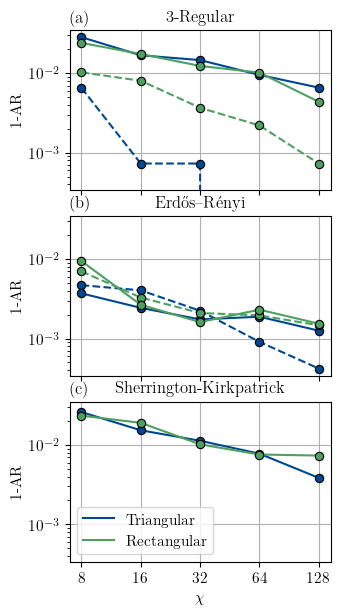

In [4]:
from matplotlib.lines import Line2D

Nvertices = 100
num_instances = 10
chi_list = [8, 16, 32, 64, 128]

graph_types = ["MaxCut/3Reg", "MaxCut/ER", "MaxCut/SK"]
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
for col, graph_type in enumerate(graph_types):

    for row, architecture in enumerate(["triangular", "quadratic"]):
        for qubit_ordering in ["fiedler", "shuffle"]:

            if qubit_ordering == "fiedler" and graph_type == "MaxCut/SK":
                continue

            avg_final_AR_list = np.zeros(len(chi_list))
            std_final_AR_list = np.zeros(len(chi_list))
            for i, chi in enumerate(chi_list):
                best_energy_list = []

                for idx in range(num_instances):
                    data_path = os.path.join("..", "results", graph_type, f"{Nvertices}v", "MPS_final", f"ising_graph{idx}_{architecture}_chi{chi}_{qubit_ordering}/results.h5")
                    with h5py.File(data_path, "r") as data:
                        samples = data["energy_samples"][:]
                        best_sample = samples.min(axis=1)
                        best_energy_list.append(best_sample)
                        avg_energy = samples.mean(axis=1)
                        avg_energy_list.append(avg_energy)

                energy = pandas.DataFrame(best_energy_list).T

                gurobi_path = os.path.join("..", "gurobi_results", graph_type, f"{Nvertices}v", "gurobi_costs.csv")
                gurobi_cost = pandas.read_csv(gurobi_path)[:num_instances]

                biqcrunch_path = f"../benchmark/BiqCrunch/results/{graph_type}/graphs/biqcrunch_results.csv"
                biqcrunch_cost = -pandas.read_csv(biqcrunch_path)["cost"][:num_instances]
                #print(biqcrunch_cost.values == gurobi_cost["cost"].values)
                # print(gurobi_cost["cost"].values)
                # print(biqcrunch_cost.values)

                # fill best_energy DataFrame such that each col has same length, by fillins NAns with the last value in that col, use padding
                energy = energy.ffill().cummin()

                final_AR = (energy / gurobi_cost["cost"].values).iloc[-1, :]
                #ax.boxplot(final_AR, positions=[i+1], widths=0.6)

                # get AR by dividing col i by gurobi_cost["cost"][i]
                avg_final_AR = (energy / gurobi_cost["cost"].values).iloc[-1, :].mean()
                std_final_AR = (energy / gurobi_cost["cost"].values).iloc[-1, :].std()
                avg_final_AR_list[i] = avg_final_AR
                std_final_AR_list[i] = std_final_AR

                if chi == 16:
                    print(f"{graph_type}, {architecture}, {qubit_ordering}: {1-avg_final_AR} +/- {std_final_AR}")
                    # Print probability of optimal, that is number of instances for which final_AR == 1
                    opt_count = np.sum(final_AR == 1)
                    print(f"Optimum count: {opt_count}")


                #print(final_AR)

            # Plot C0 / C1 color - blue for quadratic , orange for triangular
            if architecture == "quadratic":
                color = "C1"
            else:
                color = "C0"

            # Plot - / -- for fiedler, : for shuffle
            if qubit_ordering == "fiedler":
                linestyle = "--"
            else:
                linestyle = "-"

            ax[col].semilogy(
                1-avg_final_AR_list,
                linestyle=linestyle,
                color=color,
                markeredgecolor="black",
                marker="o",
                markersize=6,
                markeredgewidth=.8,
                label =f"{architecture}"
            )
            ax[col].grid(True)

ax[0].set_title("3-Regular")
ax[1].set_title("Erdős–Rényi")
ax[2].set_title("Sherrington-Kirkpatrick")

ax[0].set_title("(a)", loc='left')
ax[1].set_title("(b)", loc='left')
ax[2].set_title("(c)", loc='left')

ax[2].set_xlabel(r"$\chi$")
ax[2].set_ylabel("1-AR")
ax[0].set_ylabel("1-AR")
ax[1].set_ylabel("1-AR")

ax[1].set_xticklabels([8, 16, 32, 64, 128])
ax[1].set_xticks([0, 1, 2, 3, 4])

legend_elements = [
    Line2D([0], [0], color='C0', linestyle='-', label='Triangular'),
    Line2D([0], [0], color='C1', linestyle='-', label='Rectangular')
]
ax[2].legend(handles=legend_elements, loc='lower left')

fig.set_size_inches(set_size(fraction=1, subplots=(3, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=.01)

# save as pdf
fig.savefig("paper_figures/AR_architechture_MC.pdf", bbox_inches='tight')

# AR vs $\tau$

Graph type: MaxCut/3Reg triangular shuffle
           0         1         2         3         4         5         6  \
0   0.686131  0.681159  0.720588  0.647482  0.678832  0.676259  0.705882   
1   0.963504  0.956522  0.955882  1.000000  0.978102  0.978417  0.977941   
2   0.992701  0.978261  0.963235  1.000000  1.000000  1.000000  1.000000   
3   0.992701  0.978261  0.963235  1.000000  1.000000  1.000000  1.000000   
4   0.992701  0.978261  0.970588  1.000000  1.000000  1.000000  1.000000   
5   0.992701  0.978261  0.970588  1.000000  1.000000  1.000000  1.000000   
6   0.992701  0.978261  0.970588  1.000000  1.000000  1.000000  1.000000   
7   0.992701  0.985507  0.970588  1.000000  1.000000  1.000000  1.000000   
8   0.992701  0.985507  0.970588  1.000000  1.000000  1.000000  1.000000   
9   0.992701  0.985507  0.970588  1.000000  1.000000  1.000000  1.000000   
10  0.992701  0.985507  0.970588  1.000000  1.000000  1.000000  1.000000   
11  0.992701  0.985507  0.970588  1.000000  1

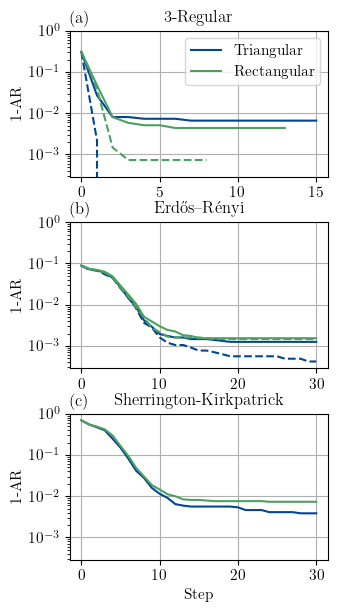

In [5]:
Nvertices = 100
num_instances = 10
chi = 128
graph_types = ["MaxCut/3Reg", "MaxCut/ER", "MaxCut/SK"]

fig, ax = plt.subplots(3, 1, sharey=True)
for i, graph_type in enumerate(graph_types):
    for architecture in ["triangular", "quadratic"]:
        for qubit_ordering in ["shuffle", "fiedler"]:
            if qubit_ordering == "fiedler" and graph_type == "MaxCut/SK":
                continue
            
            best_energy_list = []
            avg_energy_list = []

            for idx in range(num_instances):
                data_path = os.path.join("..", "results", graph_type, f"{Nvertices}v", "MPS_final", f"ising_graph{idx}_{architecture}_chi{chi}_{qubit_ordering}/results.h5")
                with h5py.File(data_path, "r") as data:
                    samples = data["energy_samples"][:]
                    best_sample = samples.min(axis=1)
                    best_energy_list.append(best_sample)
                    avg_energy = samples.mean(axis=1)
                    avg_energy_list.append(avg_energy)

            best_energy = pandas.DataFrame(best_energy_list).T
            avg_energy = pandas.DataFrame(avg_energy_list).T

            gurobi_path = os.path.join("..", "gurobi_results", graph_type, f"{Nvertices}v", "gurobi_costs.csv")
            gurobi_cost = pandas.read_csv(gurobi_path)[:num_instances]

            # fill best_energy DataFrame such that each col has same length, by fillins NAns with the last value in that col, use padding
            best_energy = best_energy.ffill().cummin()

            # get AR by dividing col i by gurobi_cost["cost"][i]
            best_AR = best_energy / gurobi_cost["cost"].values
            print("Graph type:", graph_type, architecture, qubit_ordering)
            print(best_AR)

            if architecture == "quadratic":
                color = "C1"
            else:
                color = "C0"

            # Plot - / -- for fiedler, : for shuffle
            if qubit_ordering == "fiedler":
                linestyle = "--"
            else:
                linestyle = "-"

            ax[i].semilogy(1-best_AR.mean(axis=1), color=color, linestyle=linestyle, markeredgecolor="black", markersize=5, markeredgewidth=.8, label=f"{architecture}")
            #ax[i].fill_between(range(len(best_AR)), 1-best_AR.min(axis=1), 1-best_AR.max(axis=1), alpha=0.2)
            #ax[i].errorbar(range(len(best_AR)), best_AR.mean(axis=1), yerr=best_AR.std(axis=1), fmt='o', linestyle="--", markeredgecolor="black", markersize=5, markeredgewidth=.8, label=f"{architecture}, {qubit_ordering}")
            ax[i].set_title(graph_type)
            ax[i].grid(True)
            

ax[0].set_title("3-Regular")
ax[1].set_title("Erdős–Rényi")
ax[2].set_title("Sherrington-Kirkpatrick")

ax[0].set_title("(a)", loc='left')
ax[1].set_title("(b)", loc='left')
ax[2].set_title("(c)", loc='left')

ax[0].set_ylabel("1-AR")
ax[1].set_ylabel("1-AR")
ax[2].set_ylabel("1-AR")

ax[2].set_xlabel("Step")

legend_elements = [
    Line2D([0], [0], color='C0', linestyle='-', label='Triangular'),
    Line2D([0], [0], color='C1', linestyle='-', label='Rectangular')
]
ax[0].legend(handles=legend_elements, loc='upper right')

fig.set_size_inches(set_size(fraction=1, subplots=(3, 1)))
fig.set_dpi(100)

# Increase padding between subplots
fig.tight_layout(pad=.1)

# save as pdf
fig.savefig("paper_figures/AR_vs_tau.pdf", bbox_inches='tight')

# Runtime

Avg runtime for chi 8 and 3Reg: 6.669773251054778 +/- 0.1602711807116426
Avg runtime for chi 16 and 3Reg: 6.767859056869915 +/- 0.1457785977844334
Avg runtime for chi 32 and 3Reg: 8.157934365766002 +/- 0.31334532114283276
Avg runtime for chi 64 and 3Reg: 13.867648820567226 +/- 1.2773354999278805
Avg runtime for chi 128 and 3Reg: 35.61030103679424 +/- 9.024958323861428
Avg runtime for chi 8 and ER: 5.507086136539778 +/- 0.20173415857909632
Avg runtime for chi 16 and ER: 6.289396760265032 +/- 0.0699750193454144
Avg runtime for chi 32 and ER: 8.432830945253372 +/- 0.11173125437549668
Avg runtime for chi 64 and ER: 16.723083410660426 +/- 0.4079330284962924
Avg runtime for chi 128 and ER: 48.850529432495435 +/- 2.419788106066701
Avg runtime for chi 8 and SK: 6.136455771128337 +/- 0.2593256887196688
Avg runtime for chi 16 and SK: 6.559435132741927 +/- 0.03493951976886966
Avg runtime for chi 32 and SK: 9.5172243364652 +/- 0.2436933561977976
Avg runtime for chi 64 and SK: 17.764121894836425 +/

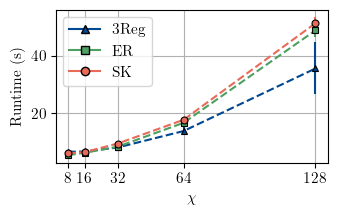

In [6]:
chi_list = [8, 16, 32, 64, 128]
from matplotlib.lines import Line2D

fig, ax = plt.subplots(sharex=True, sharey=False)


for graph_type in ["3Reg", "ER", "SK"]:
    avg_runtime_chi = np.zeros(len(chi_list))
    std_runtime_chi = np.zeros(len(chi_list))
    for i, chi in enumerate(chi_list):

        avg_runtime_list = np.array([])
        std_runtime_list = np.array([])
        for row, architecture in enumerate(["triangular", "quadratic"]):
            for qubit_ordering in ["fiedler", "shuffle"]:
                if qubit_ordering == "fiedler" and graph_type == "SK":
                    continue

                for instance in range(10, 20):
                    data_path = f"../results/MaxCut/{graph_type}/100v/MPS_final/ising_graph{instance}_{architecture}_chi{chi}_{qubit_ordering}/results.h5"
                    with h5py.File(data_path, "r") as data:
                        samples = data["energy_samples"][:]
                        runtime = data["runtime"][:]
                        best_sample = samples.min(axis=1)
                        avg_energy = samples.mean(axis=1)

                    avg_runtime_list = np.append(avg_runtime_list, np.diff(runtime).mean())
                    std_runtime_list = np.append(std_runtime_list, np.diff(runtime).std())
                    #print(np.diff(runtime).mean())


        print(f"Avg runtime for chi {chi} and {graph_type}: {avg_runtime_list.mean()} +/- {avg_runtime_list.std()}")
        avg_runtime_chi[i] = avg_runtime_list.mean()
        std_runtime_chi[i] = avg_runtime_list.std()

    # Assign marker based on graph_type
    if graph_type == "3Reg":
        marker = "^"
        color = "C0"
    elif graph_type == "ER":
        marker = "s"
        color = "C1"
    else:
        marker = "o"
        color = "C2"

    ax.errorbar(
        chi_list,
        avg_runtime_chi,
        yerr=std_runtime_chi,
        marker=marker,
        linestyle="--",
        markeredgecolor="black",
        markersize=5,
        markeredgewidth=.8,
        color=color,
        label=graph_type
    )

# fit to 4th degree polynomial
ax.grid()
ax.set_xlabel(r"$\chi$")
ax.set_ylabel("Runtime (s)")
ax.set_xticks(chi_list)
ax.set_xticklabels(chi_list)
legend_elements = [
    Line2D([0], [0], color='C0', linestyle='-', marker='^', markeredgecolor="black", label='3Reg'),
    Line2D([0], [0], color='C1', linestyle='-', marker='s', markeredgecolor="black", label='ER'),
    Line2D([0], [0], color='C2', linestyle='-', marker='o', markeredgecolor="black", label='SK')
]
ax.legend(handles=legend_elements, loc='upper left')

fig.set_size_inches(set_size(fraction=1, subplots=(1, 1)))

# save
fig.set_dpi(100)
fig.tight_layout(pad=.1)

fig.savefig("paper_figures/runtime_vs_chi.pdf", bbox_inches='tight')

# Distribution vs $\tau$

0
5
10
15


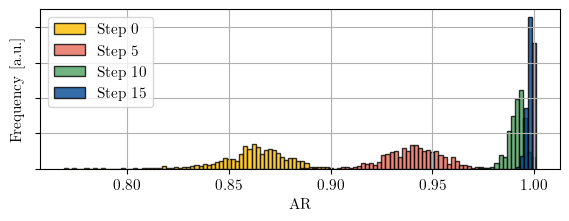

In [8]:
data_path = "../results/MaxCut/ER/100v/MPS_fix_dt/ising_graph0_triangular_chi128_shuffle/results.h5"
gurobi_path = os.path.join("..", "gurobi_results", "MaxCut", "ER", "100v", "gurobi_costs.csv")
gurobi_cost = pandas.read_csv(gurobi_path).iloc[0]

with h5py.File(data_path, "r") as data:
    samples = data["energy_samples"][:] / gurobi_cost.item()
    

# for each row, plot histogram of the values in that row in a single figure
fig, ax = plt.subplots(1, 1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for idx, i in enumerate(range(0, 17, 5)):
    print(i)
    color = colors[::-1][idx % len(colors)]
    min_val = samples[i, :].min()
    max_val = samples[i, :].max()
    bins = np.arange(min_val, max_val + 0.002, 0.002)  # binwidth of 0.01
    ax.hist(samples[i, :], bins=bins, density=True, alpha=.8, edgecolor='black', label=f"Step {i}", color=color)
ax.set_xlabel("AR")
ax.set_ylabel("Frequency [a.u.]")
ax.set_yticklabels([])

ax.grid(True)
ax.legend()

fig.set_size_inches(set_size(width='full', fraction=1, subplots=(1, 1), squeeze_height=0.5))

# Save
fig.savefig("paper_figures/energy_histogram.pdf", bbox_inches='tight')

# Entanglement entropy

-1428.0


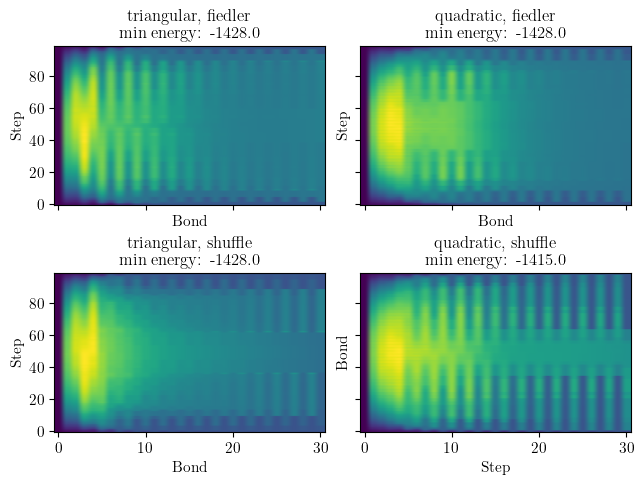

In [12]:
chi = 128

architecture = "triangular"
qubit_ordering = "shuffle"
graph_type = "ER"
idx = 2

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

data_path = os.path.join("..", "results", "MaxCut", graph_type, f"{Nvertices}v", "MPS_fix_dt", f"ising_graph{idx}_triangular_chi{chi}_fiedler/results.h5")
with h5py.File(data_path, "r") as data:
    ee_vals = data[f"entanglement_entropy"][:] # Shape (num_bonds, num_steps)
    samples = data["energy_samples"][:]

print(samples.min())
axes[0, 0].imshow(ee_vals, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title("triangular, fiedler\nmin energy: " + str(samples.min()))
axes[0, 0].set_xlabel("Bond")
axes[0, 0].set_ylabel("Step")
#plt.title("Entanglement Entropy Heatmap")

data_path = os.path.join("..", "results", "MaxCut", graph_type, f"{Nvertices}v", "MPS_fix_dt", f"ising_graph{idx}_quadratic_chi{chi}_fiedler/results.h5")
with h5py.File(data_path, "r") as data:
    ee_vals = data[f"entanglement_entropy"][:] # Shape (num_bonds, num_steps)
    samples = data["energy_samples"][:]

axes[0, 1].imshow(ee_vals, aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title("quadratic, fiedler\nmin energy: " + str(samples.min()))
axes[0, 1].set_xlabel("Bond")
axes[0, 1].set_ylabel("Step")

data_path = os.path.join("..", "results", "MaxCut", graph_type, f"{Nvertices}v", "MPS_fix_dt", f"ising_graph{idx}_triangular_chi{chi}_shuffle/results.h5")
with h5py.File(data_path, "r") as data:
    ee_vals = data[f"entanglement_entropy"][:] # Shape (num_bonds, num_steps)
    samples = data["energy_samples"][:]

axes[1, 0].imshow(ee_vals, aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title("triangular, shuffle\nmin energy: " + str(samples.min()))
axes[1, 0].set_xlabel("Bond")
axes[1, 0].set_ylabel("Step")

data_path = os.path.join("..", "results", "MaxCut", graph_type, f"{Nvertices}v", "MPS_fix_dt", f"ising_graph{idx}_quadratic_chi{chi}_shuffle/results.h5")
with h5py.File(data_path, "r") as data:
    ee_vals = data[f"entanglement_entropy"][:] # Shape (num_bonds, num_steps)
    samples = data["energy_samples"][:]

axes[1, 1].imshow(ee_vals, aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title("quadratic, shuffle\nmin energy: " + str(samples.min()))
axes[1, 1].set_xlabel("Step")
axes[1, 1].set_ylabel("Bond")

fig.tight_layout(pad=.5)
# add a bar for the cmap